# Enable Virtual Environment For This Notebook.

### Activate Conda Environment

<b>`$ conda activate`</b>

### Install Or Upgrade necessary software for virtual environment.

<b>`$ sudo apt-get install --upgrade python3-pip`</b>

<b>`$ sudo pip3 install --upgrade virtualenv`</b>

<b>`$ sudo pip3 install --upgrade setuptools`</b>

Now we will go to the location of the directory, where we will create our virtual environment.

<b>`$ cd /media/mujahid7292/Data/GoogleDri
rning/WEEK_3/01.Using_Custom_Estimatorsmujahid7292@mujahid7292-HP-ENVY-Notebook:/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimat`</b>

### Deactivate conda environment

<b>`$ conda deactivate`</b>

### Create Virtual Environment

<b>`$ virtualenv Venv`</b>

### Activate newly created virtual environment

<b>`$ source Venv/bin/activate`</b>

<b>`$ (Venv) which python`</b>

<b>`$ (Venv) pip list`</b>

<b>`$ (Venv) pip3 install jupyter`</b>

In [ ]:
%%writefile requirements.txt
numpy
pandas
seaborn
tensorflow==1.8.0

In [ ]:
%%bash
pip3 install -r requirements.txt

In [ ]:
%%bash
pip3 list

In [ ]:
%%bash
which python

In [ ]:
%%bash
python --version

<a>https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/05_artandscience/d_customestimator.ipynb</a>

<h1> Time series prediction using RNNs, with TensorFlow and Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.estimator
<li> Training on Cloud ML Engine
</ol>

<p>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [1]:
import os
PROJECT = 'ml-practice-260405'
BUCKET = 'bucket-ml-practice-260405'
REGION = 'us-central1'
os.environ['TFVERSION'] = '1.8'

In [2]:
# For bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [4]:
import tensorflow as tf
print(tf.__version__)

/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Cu

1.8.0


### Random time series generator function

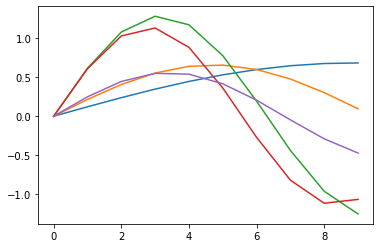

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

SEQ_LEN = 10
def create_timeseries():
    """
    """
    freq = (np.random.random() *0.5) + 0.1 # 0.1 to 0.6
    ampl = np.random.random() + 0.5 # 0.5 to 1.5
    x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
    return x

# Plot our time series data
for i in range(0,5):
    sns.lineplot(data=create_timeseries()) # 5 Series

### Create training and evaluation dataset

In [6]:
def to_csv(filename, N):
    """
    """
    with open(file=filename, mode='w') as ofp:
        for lineno in range(0, N):
            seq = create_timeseries()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')
            
to_csv('train.csv', 1000) # 1000 Sequences
to_csv('valid.csv', 50)

In [7]:
!head -5 train.csv valid.csv

==> train.csv <==
0.0,0.2846975031846363,0.5577225722601126,0.8078813362114603,1.0249174294001042,1.199932496664106,1.325751020768865,1.3972145144923407,1.411393015638284,1.3677052138034018
0.0,0.08050965668107063,0.15918547506966776,0.23423538779896313,0.30394991790080883,0.3667411170456152,0.42117873561900077,0.4660228007580032,0.5002518602886573,0.5230862492282725
0.0,0.4833623659951605,0.8481459271028067,1.0048617165315328,0.9150641035810628,0.6007823035451765,0.13911615469826166,-0.356678069739941,-0.7649717723858219,-0.9856020470868334
0.0,0.41318310276072184,0.7067185736708541,0.795605782927576,0.6541051878963634,0.32319186957112234,-0.1013098398794529,-0.4964747193780086,-0.7478727699564935,-0.782705319058858
0.0,0.5869255807640114,1.0503853041986508,1.2928856311451626,1.2634141134322987,0.9681703891751328,0.46926202487140883,-0.12836045262098728,-0.6989809832747286,-1.1225636454399242

==> valid.csv <==
0.0,0.44927125153099895,0.8283523059075627,1.0780188663300856,1.1592652206

<h2> RNN </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

Here, we are trying to predict from 9 values of a timeseries, the tenth value.

<p>

<h3> Imports </h3>

Several tensorflow packages and shutil

In [8]:
import tensorflow as tf
import shutil
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

<h3> Input Fn to read CSV </h3>

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.  The Estimator API in tf.contrib.learn wants the features returned as a dict. We'll just call this timeseries column 'rawdata'.
<p>
Our CSV file sequences consist of 10 numbers. We'll assume that 9 of them are inputs and we need to predict the last one.

In [9]:
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
# In each sequence, column index 0 to N_INPUTS - 1 are features, and column 
# index N_INPUTS to SEQ_LEN are labels
N_OUTPUTS = 1
N_INPUTS = SEQ_LEN - N_OUTPUTS

Reading data using the Estimator API in tf.estimator requires an input_fn. This input_fn needs to return a dict of features and the corresponding labels.
<p>
So, we read the CSV file.  The Tensor format here will be a scalar -- entire line.  We then decode the CSV. At this point, all_data will contain a list of scalar Tensors. There will be SEQ_LEN of these tensors.
<p>
We split this list of SEQ_LEN tensors into a list of N_INPUTS Tensors and a list of N_OUTPUTS Tensors. We stack them along the first dimension to then get a vector Tensor for each.  We then put the inputs into a dict and call it features.  The other is the ground truth, so labels.

### Read data and convert to needed format

In [21]:
def read_dataset(filename, mode, batch_size=512):
    """
    """
    def _input_fn():
        """
        Provide the ability to decode a CSV
        """
        def decode_csv(line):
            """
            """
            # all_data is a list of scalar tensor
            all_data = tf.decode_csv(records=line, record_defaults=DEFAULTS)
            inputs = all_data[:len(all_data) - N_OUTPUTS] # First N Inputs Value
            labels = all_data[len(all_data) - N_OUTPUTS:] # Last N Outputs Value
            
            # Convert each list of rank R tensors to one rank R+1 tensors
            inputs = tf.stack(values=inputs, axis=0)
            labels = tf.stack(values=labels, axis=0)
            
            # Convert input R+1 tensor into a feature dictionary of one R+1 tensor
            features = {TIMESERIES_COL: inputs}
            
            return features, labels
        
        # Create list of file that match pattern
        file_list = tf.gfile.Glob(filename=filename)
        
        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames=file_list).map(decode_csv)
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # Run Indefinietly
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # End of input after this
        
        dataset = dataset.repeat(num_epochs).batch(batch_size)
        iterator = dataset.make_one_shot_iterator()
        
        batch_features, batch_labels = iterator.get_next()
        
        return batch_features, batch_labels
    return _input_fn

<h3> Define RNN </h3>

A recursive neural network consists of possibly stacked LSTM cells.
<p>
The RNN has one output per input, so it will have 8 output cells.  We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).
<p>
Finally, to supply a model function to the Estimator API, you need to return a EstimatorSpec. The rest of the function creates the necessary objects.

In [22]:
LSTM_SIZE = 3 # Number of hidden layer in each of the LSTM cells

# Create the inference model
def simple_rnn(features, labels, mode):
    """
    """
    # 0. Reformat input shape to become a sequence
    x = tf.split(
        value=features[TIMESERIES_COL],
        num_or_size_splits=N_INPUTS,
        axis=1
    )
    
    # 1. Configure the rnn
    lstm_cell = rnn.BasicLSTMCell(
        num_units=LSTM_SIZE,
        forget_bias=1.0
    )
    outputs, _ = rnn.static_rnn(
        cell=lstm_cell,
        inputs=x,
        dtype=tf.float32
    )
    
    # Slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    
    # Output is result of linear activation of last layer of RNN
    weight = tf.get_variable(
        name='weight',
        initializer=tf.initializers.random_normal,
        shape=[LSTM_SIZE, N_OUTPUTS]
    )
    bias = tf.get_variable(
        name='bias',
        initializer=tf.initializers.random_normal,
        shape=[N_OUTPUTS]
    )

    predictions = tf.matmul(outputs, weight) + bias
    
    # 2. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        # Our loss function
        loss = tf.losses.mean_squared_error(labels, predictions)
        # Our training optimizer
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=0.01,
            optimizer='SGD'
        )
        # Our evaluation metric optimizer
        eval_metric_ops = {
            'rmse':tf.metrics.root_mean_squared_error(labels, predictions)
        }
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
    
    # 3. Create predictions
    predictions_dict = {'predicted':predictions}
    
    # 4. Create export output
    export_outputs = {
        "predicted_export_outputs": tf.estimator.export.PredictOutput(outputs=predictions)
    }
    
    # 5. Return estimator spec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs
    )

<h3> Estimator </h3>

Distributed training is launched off using an Estimator.  The key line here is that we use tf.estimator.Estimator rather than, say tf.estimator.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time.

### Create function to read in respected dataset

In [23]:
def get_train():
    """
    """
    return read_dataset(
        filename='train.csv',
        mode=tf.estimator.ModeKeys.TRAIN,
        batch_size=512
    )

def get_valid():
    """
    """
    return read_dataset(
        filename='valid.csv',
        mode=tf.estimator.ModeKeys.EVAL,
        batch_size=512
    )

### Create serving input function

In [24]:
def serving_input_fn():
    """
    """
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(dtype=tf.float32, shape=[None, N_INPUTS])
    }
    
    features = {
        key: tf.expand_dims(input=tensor, axis=-1)
        for key, tensor in feature_placeholders.items()
    }
    
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis = [2])
    
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

## Create custom estimator's train and evaluate function

In [25]:
def train_and_evaluate(output_dir):
    """
    """
    estimator = tf.estimator.Estimator(
        model_fn=simple_rnn,
        model_dir=output_dir
    )
    
    train_spec = tf.estimator.TrainSpec(
        input_fn=get_train(),
        max_steps=1000
    )
    
    exporter = tf.estimator.LatestExporter(
        'exporter', 
        serving_input_fn
    )
    
    eval_spec = tf.estimator.EvalSpec(
        input_fn=get_valid(),
        steps=None,
        exporters=exporter
    )
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

## Run the model

In [26]:
shutil.rmtree('outputdir', ignore_errors = True) # start fresh each time
train_and_evaluate('outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3043ac4160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:G

<h3> Standalone Python module </h3>

To train this on Cloud ML Engine, we take the code in this notebook and make a standalone Python module.

# Create command line programme

In order to submit to `Cloud AI Platform`, we need to create a distributed training programme. Let's convert our time series example to fit that paradigm, using the Estimator API.

In [27]:
%%bash
rm -rf simple_rnn
mkdir simple_rnn
mkdir simple_rnn/trainer
touch simple_rnn/trainer/__init__.py

In [28]:
%%writefile simple_rnn/trainer/task.py

"""
Example implementation of code to run on the Cloud ML service
"""

import traceback
import argparse
import json
import os

from .import model

import shutil
import tensorflow as tf

if __name__ == '__main__':
    
    # Create object of ArgumentParser class
    parser = argparse.ArgumentParser()
    
    # Input arguments
    parser.add_argument(
        '--train_data_paths',
        help = 'GCS or local path to training data',
        required=True
    )
    
    parser.add_argument(
        '--eval_data_paths',
        help = 'GCS or local path to evaluation data',
        required=True
    )
    
    parser.add_argument(
        '--output_dir',
        help = 'GCS location to write checkpoints and export models',
        required=True
    )
    
    parser.add_argument(
        '--job-dir',
        help = 'This model ignore this field, but it is required by gcloud',
        default='junk'
    )
    
    parser.add_argument(
        '--keras',
        help = 'Use the keras variant',
        action = 'store_true'
    )
    
    # Eval arguments
    parser.add_argument(
        '--eval_delay_secs',
        help = 'How long to wait before running first evaluation',
        default = 10,
        type = int
    )
    
    parser.add_argument(
        '--min_eval_frequency',
        help = 'Minimum number of training steps between evaluations',
        default = 1,
        type = int
    )
    
    # Now parse those above arguments
    args = parser.parse_args()
    arguments = args.__dict__
    
    # Unused args provided by service
    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)
    
    output_dir = arguments.pop('output_dir')

    # Append trial_id to path if we are doing hptuning
    # This code can be removed if you are not using hyperparameter tuning
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get('TF_CONFIG', '{}')
        ).get('task', {}).get('trial', '')
    )

    # Run the training job
    try:
        shutil.rmtree(output_dir, ignore_errors = True) # start fresh each time
        model.train_and_evaluate(output_dir, arguments['keras'])
    except:
        traceback.print_exc()

Writing simple_rnn/trainer/task.py


In [44]:
%%writefile simple_rnn/trainer/model.py

import tensorflow as tf
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

tf.logging.set_verbosity(tf.logging.INFO)

SEQ_LEN = 10
DEFAULTS = [[0.0] for x in range(0,SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_INPUT_LAYER = 'rawdata'
TIMESERIES_COL = '{}.input'.format(TIMESERIES_INPUT_LAYER)
# In each sequence, column index 0 to (N_INPUTS - 1) are features, and 
# column index N_INPUTS to SEQ_LEN are labels. Example: here first 9 inputs
# are features and 10th inputs are label
N_OUTPUTS = 1
N_INPUTS = SEQ_LEN - N_OUTPUTS # e.g: 10 - 1 = 9
LSTM_SIZE = 3 # NUmber of hidden layer in each of the lstm cell

# Read data and convert to needed format
def read_dataset(filename, mode, batch_size):
    """
    """
    def _input_fn():
        """
        Provide the ability to decode a csv
        """
        def decode_csv(line):
            """
            """
            # all_data is a list of scalar tensor
            all_data = tf.decode_csv(
                records=line,
                record_defaults=DEFAULTS
            )
            inputs = all_data[:len(all_data) - N_OUTPUTS]  # first N_INPUTS values
            labels = all_data[len(all_data) - N_OUTPUTS:] # last N_OUTPUTS values

            # Convert each list of rank R tensors to one rank R+1 tensor
            inputs = tf.stack(inputs, axis = 0)
            labels = tf.stack(labels, axis = 0)
            
            # Convert input R+1 tensor into a feature dictionary of one R+1 tensor
            features = {TIMESERIES_COL: inputs}
            
            return features, labels
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)

        iterator = dataset.make_one_shot_iterator()
        batch_features, batch_labels = iterator.get_next()
        
        return batch_features, batch_labels
    return _input_fn

# Create inference model usin keras.
# The model here is a dnn regressor.
def make_keras_estimator(output_dir):
    """
    """
    from tensorflow import keras
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        32, 
        input_shape=(N_INPUTS,), 
        name=TIMESERIES_INPUT_LAYER
    ))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1))
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mae','mape'] # mean absolute [percentage] error
    )
    
    return keras.estimator.model_to_estimator(model, model_dir=output_dir)

# Create the inference model
def simple_rnn(features, labels, mode):
    # 0. Reformat input shape to become a sequence
    x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)

    # 1. Configure the RNN
    lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias = 1.0)
    outputs, _ = rnn.static_rnn(lstm_cell, x, dtype = tf.float32)

    # Slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    #print('last outputs={}'.format(outputs))

    # Output is result of linear activation of last layer of RNN
    weight = tf.get_variable("weight", initializer=tf.initializers.random_normal, 
			     shape=[LSTM_SIZE, N_OUTPUTS])
    bias = tf.get_variable("bias", initializer=tf.initializers.random_normal, 
			   shape=[N_OUTPUTS])
    predictions = tf.matmul(outputs, weight) + bias
    
    # 2. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.losses.mean_squared_error(labels, predictions)
        train_op = tf.contrib.layers.optimize_loss(
            loss = loss,
            global_step = tf.train.get_global_step(),
            learning_rate = 0.01,
            optimizer = "SGD")
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
        }
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
  
    # 3. Create predictions
    predictions_dict = {"predicted": predictions}
    
    # 4. Create export outputs
    export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions)}

    # 4. Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs)

# Create serving input function
def serving_input_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }

    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis = [2])

    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

# Create custom estimator's train and evaluate function
def train_and_evaluate(output_dir, use_keras):
    if use_keras:
       estimator = make_keras_estimator(output_dir)
    else:
       estimator = tf.estimator.Estimator(model_fn = simple_rnn, 
                                          model_dir = output_dir)
    train_spec = tf.estimator.TrainSpec(read_dataset('train.csv',
                                            tf.estimator.ModeKeys.TRAIN,
                                            512),
                                        max_steps = 1000)
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(read_dataset('valid.csv',
                                            tf.estimator.ModeKeys.EVAL,
                                            512),
                                      steps = None, 
                                      exporters = exporter)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting simple_rnn/trainer/model.py


In [45]:
%%bash
# Run model as it is
# First remove the outputdir
rm -rf outputdir
echo $PWD
export PYTHONPATH=${PYTHONPATH}:${PWD}/simple_rnn
python -m trainer.task \
    --train_data_paths="${PWD}/train.csv*" \
    --eval_data_path="${PWD}/valid.csv*" \
    --output_dir=outputdir \
    --job-dir=./tmp

/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Practice


rm: cannot remove 'outputdir/eval': Directory not empty
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/0

Try out online prediction.  This is how the REST API will work after you train on Cloud ML Engine

In [47]:
%%writefile test.json
{"rawdata_input": [0,0.214,0.406,0.558,0.655,0.687,0.65,0.549,0.393]}

Writing test.json


In [51]:
%%bash
# local predict doesn't work with Python 3 yet.
MODEL_DIR=$(ls ./outputdir/export/exporter/)
gcloud ml-engine local predict --model-dir=./outputdir/export/exporter/$MODEL_DIR --json-instances=test.json

If the signature defined in the model is not serving_default then you must specify it via --signature-name flag, otherwise the command may fail.
ERROR: (gcloud.ml-engine.local.predict) RuntimeError: Bad magic number in .pyc file



CalledProcessError: Command 'b"# local predict doesn't work with Python 3 yet.\nMODEL_DIR=$(ls ./outputdir/export/exporter/)\ngcloud ml-engine local predict --model-dir=./outputdir/export/exporter/$MODEL_DIR --json-instances=test.json\n"' returned non-zero exit status 1.

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine.

In [ ]:
%%bash
# Run module on Cloud ML Engine
OUTDIR=gs://${BUCKET}/simplernn/model_trained
JOBNAME=simplernn_$(date -u +%y%m%d_%H%M%S)
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/simplernn/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.4 \
   -- \
   --train_data_paths="gs://${BUCKET}/train.csv*" \
   --eval_data_paths="gs://${BUCKET}/valid.csv*"  \
   --output_dir=$OUTDIR

<h2> Variant: long sequence </h2>

To create short sequences from a very long sequence.

In [52]:
import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in range(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print('input=', x.eval())
    seqx = breakup(sess, x, 5)
    print('output=', seqx.eval())

input= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
output= [[1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]
 [5. 6. 7. 8. 9.]]


## Variant: Keras

You can also invoke a Keras model from within the Estimator framework by creating an estimator from the compiled Keras model:

In [53]:
def make_keras_estimator(output_dir):
  from tensorflow import keras
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(32, input_shape=(N_INPUTS,), name=TIMESERIES_INPUT_LAYER))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dense(1))
  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['mae', 'mape']) # mean absolute [percentage] error
  return keras.estimator.model_to_estimator(model)

In [56]:
%%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simple_rnn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=${PWD}/outputdir \
  --job-dir=./tmp --keras

/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Practice


rm: cannot remove 'outputdir/eval': Directory not empty
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/05.Art_And_Science_Of_Machine_Learning/WEEK_3/01.Using_Custom_Estimators/Venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/0